<a href="https://colab.research.google.com/github/dxbee/ml-projects/blob/main/ShoppingTrends.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [187]:
import kagglehub
import joblib
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import classification_report, mean_squared_error, silhouette_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

# Download latest version
path = kagglehub.dataset_download("bhadramohit/customer-shopping-latest-trends-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/bhadramohit/customer-shopping-latest-trends-dataset/versions/1


In [188]:
# Define the CSV file path within the downloaded dataset
csv_file = os.path.join(path, "shopping_trends.csv")

# Load the dataset into a Pandas DataFrame

# Read the dataset into a pandas DataFrame
shopping = pd.read_csv(csv_file)
shopping.head(5)


,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Payment Method,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Preferred Payment Method,Frequency of Purchases
0,1,55,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,Yes,Credit Card,Express,Yes,Yes,14,Venmo,Fortnightly
1,2,19,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,Yes,Bank Transfer,Express,Yes,Yes,2,Cash,Fortnightly
2,3,50,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,Yes,Cash,Free Shipping,Yes,Yes,23,Credit Card,Weekly
3,4,21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,Yes,PayPal,Next Day Air,Yes,Yes,49,PayPal,Weekly
4,5,45,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,Yes,Cash,Free Shipping,Yes,Yes,31,PayPal,Annually


#**Data Exploration**

Analyze the dataset’s columns, data types, summary statistics, null values and unique value counts.

In [189]:
# Check for missing values
print("Missing Values in Each Column:")
shopping.isna().sum()


Missing Values in Each Column:


,0
Customer ID,0
Age,0
Gender,0
Item Purchased,0
Category,0
Purchase Amount (USD),0
Location,0
Size,0
Color,0
Season,0


In [190]:
# View dataset information
print("Dataset Information:")
shopping.info()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer ID               3900 non-null   int64  
 1   Age                       3900 non-null   int64  
 2   Gender                    3900 non-null   object 
 3   Item Purchased            3900 non-null   object 
 4   Category                  3900 non-null   object 
 5   Purchase Amount (USD)     3900 non-null   int64  
 6   Location                  3900 non-null   object 
 7   Size                      3900 non-null   object 
 8   Color                     3900 non-null   object 
 9   Season                    3900 non-null   object 
 10  Review Rating             3900 non-null   float64
 11  Subscription Status       3900 non-null   object 
 12  Payment Method            3900 non-null   object 
 13  Shipping Type             3900 non-null   

In [191]:
# Display basic statistical summary for numeric columns
print("Statistical Summary of Numeric Columns:")
shopping.describe()

Statistical Summary of Numeric Columns:


,Customer ID,Age,Purchase Amount (USD),Review Rating,Previous Purchases
count,3900.000000,3900.000000,3900.000000,3900.000000,3900.000000
mean,1950.500000,44.068462,59.764359,3.749949,25.351538
std,1125.977353,15.207589,23.685392,0.716223,14.447125
min,1.000000,18.000000,20.000000,2.500000,1.000000
25%,975.750000,31.000000,39.000000,3.100000,13.000000
50%,1950.500000,44.000000,60.000000,3.700000,25.000000
75%,2925.250000,57.000000,81.000000,4.400000,38.000000
max,3900.000000,70.000000,100.000000,5.000000,50.000000


In [192]:
# Display unique values and their counts for categorical columns
print("Unique Value Counts for Categorical Columns:")
categorical_columns = ['Gender', 'Category', 'Location', 'Size', 'Color', 'Season',
                       'Subscription Status', 'Payment Method', 'Shipping Type',
                       'Promo Code Used', 'Preferred Payment Method']
for column in categorical_columns:
    print(f"\n")
     # Shows unique value counts for each categorical column
    print(shopping[column].value_counts())

Unique Value Counts for Categorical Columns:


Gender
Male      2652
Female    1248
Name: count, dtype: int64


Category
Clothing       1737
Accessories    1240
Footwear        599
Outerwear       324
Name: count, dtype: int64


Location
Montana           96
California        95
Idaho             93
Illinois          92
Alabama           89
Minnesota         88
Nebraska          87
New York          87
Nevada            87
Maryland          86
Delaware          86
Vermont           85
Louisiana         84
North Dakota      83
Missouri          81
West Virginia     81
New Mexico        81
Mississippi       80
Indiana           79
Georgia           79
Kentucky          79
Arkansas          79
North Carolina    78
Connecticut       78
Virginia          77
Ohio              77
Tennessee         77
Texas             77
Maine             77
South Carolina    76
Colorado          75
Oklahoma          75
Wisconsin         75
Oregon            74
Pennsylvania      74
Washington        73
Michig

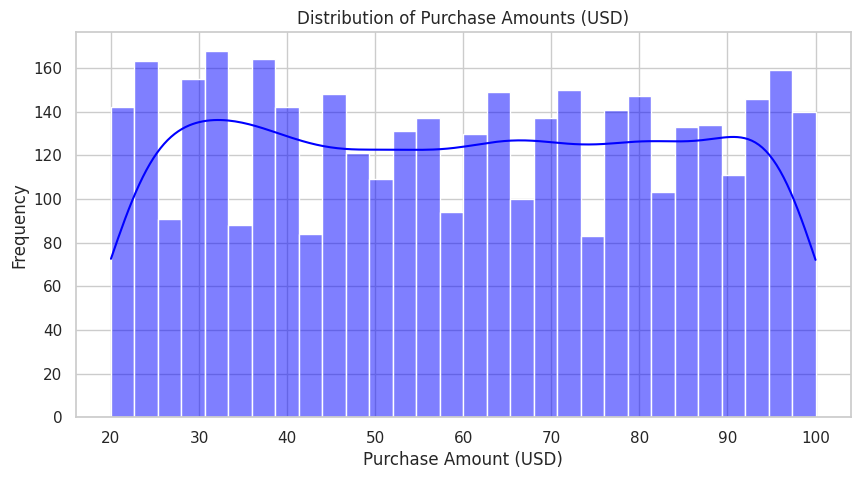

In [193]:
# Plot the distribution of 'Purchase Amount (USD)'
plt.figure(figsize=(10, 5))
sns.histplot(shopping['Purchase Amount (USD)'], kde=True, bins=30, color='blue')
plt.title('Distribution of Purchase Amounts (USD)')
plt.xlabel('Purchase Amount (USD)')
plt.ylabel('Frequency')
plt.show()

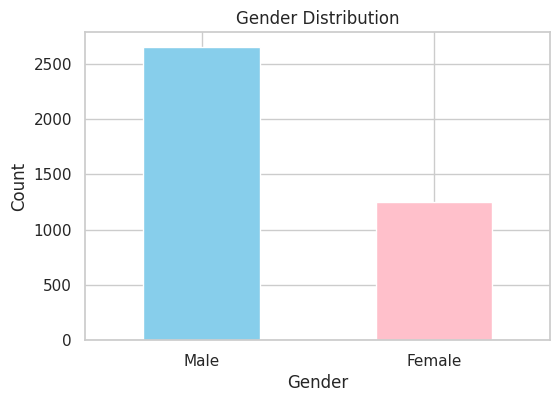

In [194]:
# Visualize gender distribution
plt.figure(figsize=(6, 4))
shopping['Gender'].value_counts().plot(kind='bar', color=['skyblue', 'pink'])
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# **Visualization**

<ipython-input-195-2d2270bd14de>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=shopping, x='Category', order=shopping['Category'].value_counts().index, palette='viridis')


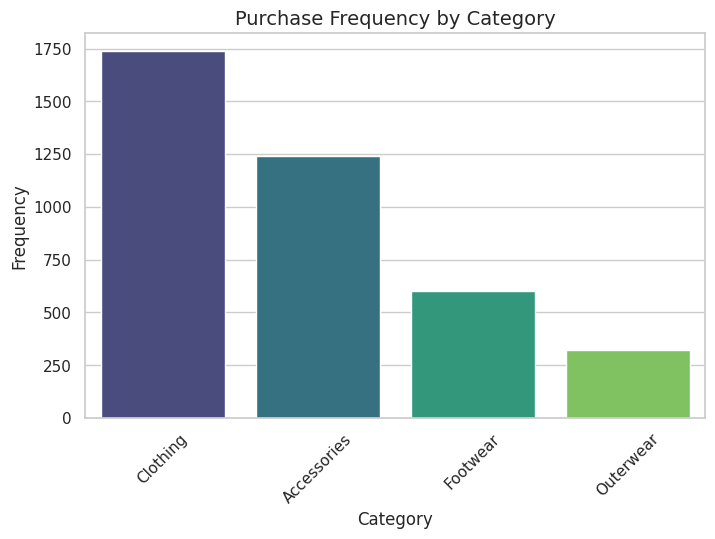

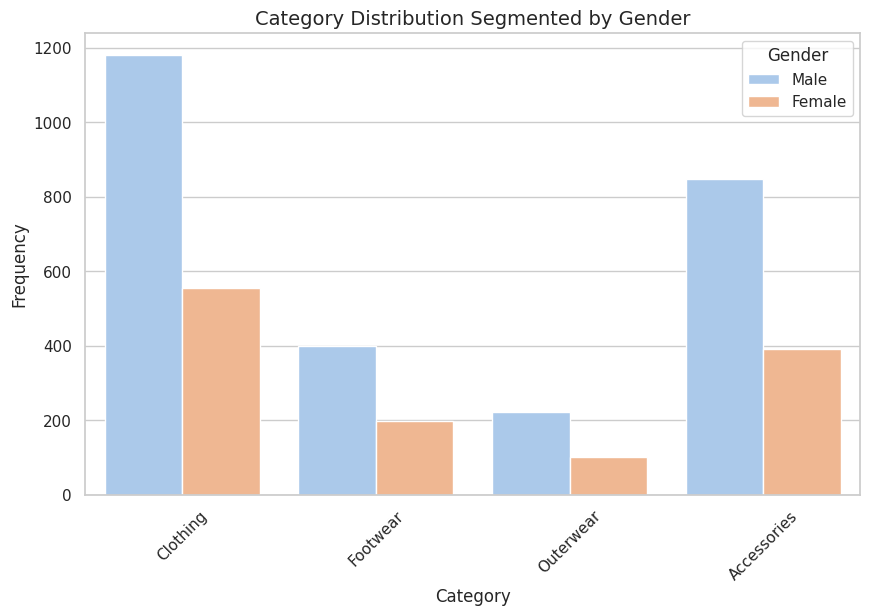

<ipython-input-195-2d2270bd14de>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=shopping, x='Season', order=shopping['Season'].value_counts().index, palette='coolwarm')


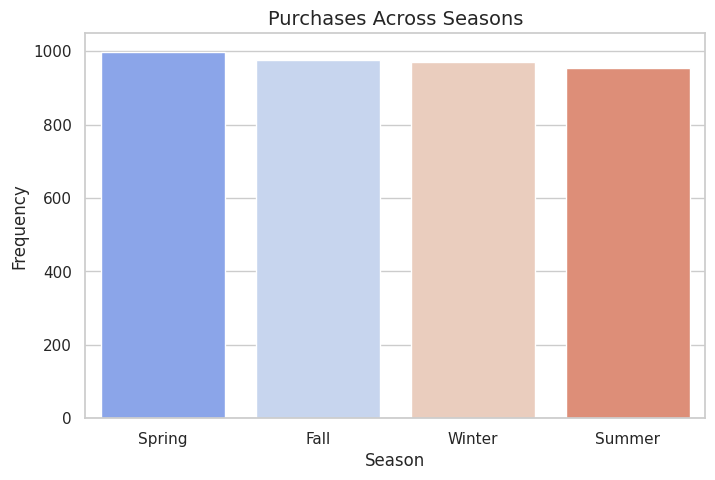

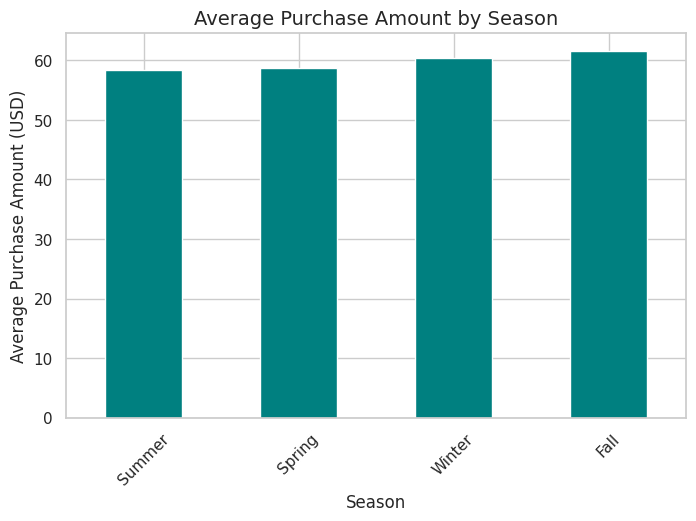

<ipython-input-195-2d2270bd14de>:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=shopping, x='Preferred Payment Method', order=shopping['Preferred Payment Method'].value_counts().index, palette='coolwarm')


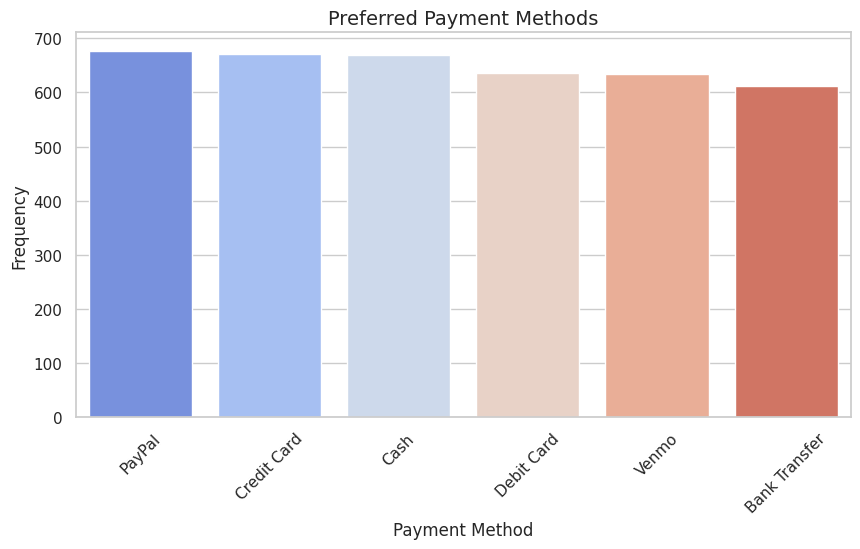

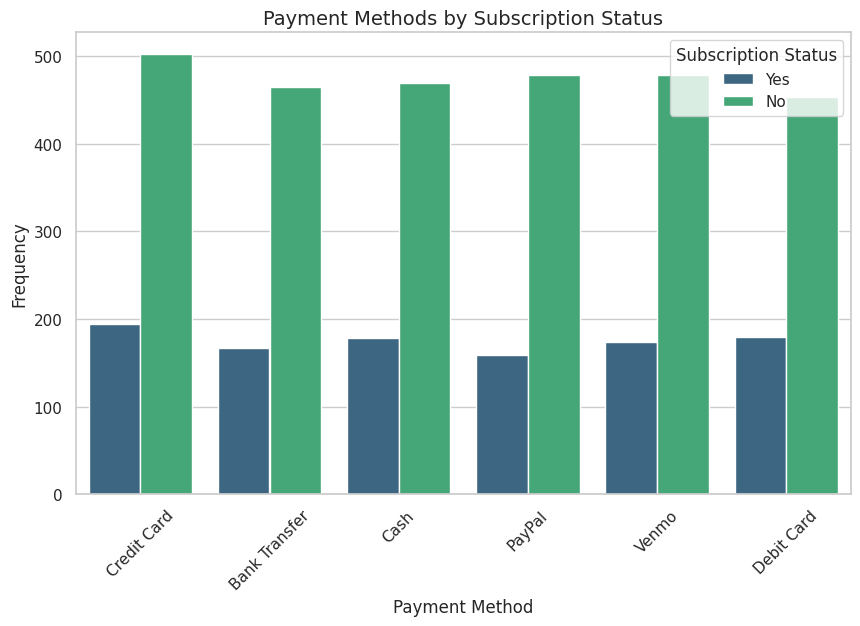

<ipython-input-195-2d2270bd14de>:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_locations.values, y=top_locations.index, palette='Blues_r')


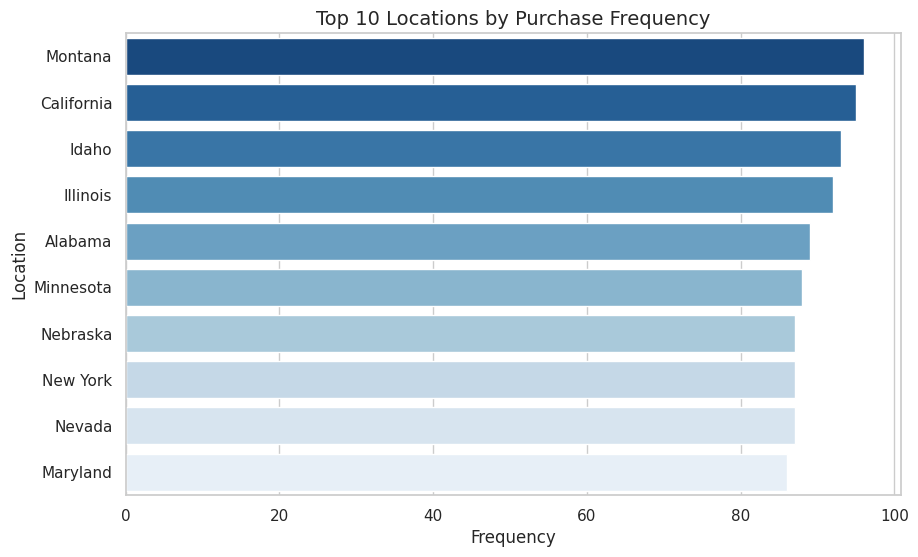

In [195]:
# Set a consistent style for plots
sns.set(style="whitegrid")

# Purchase Frequency by Category
plt.figure(figsize=(8, 5))
sns.countplot(data=shopping, x='Category', order=shopping['Category'].value_counts().index, palette='viridis')
plt.title('Purchase Frequency by Category', fontsize=14)
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

# Category Distribution by Gender
plt.figure(figsize=(10, 6))
sns.countplot(data=shopping, x='Category', hue='Gender', palette='pastel')
plt.title('Category Distribution Segmented by Gender', fontsize=14)
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.legend(title='Gender', loc='upper right')
plt.xticks(rotation=45)
plt.show()

# Purchases Across Seasons
plt.figure(figsize=(8, 5))
sns.countplot(data=shopping, x='Season', order=shopping['Season'].value_counts().index, palette='coolwarm')
plt.title('Purchases Across Seasons', fontsize=14)
plt.xlabel('Season')
plt.ylabel('Frequency')
plt.show()

# Average Purchase Amount by Season
avg_purchase_season = shopping.groupby('Season')['Purchase Amount (USD)'].mean().sort_values()
plt.figure(figsize=(8, 5))
avg_purchase_season.plot(kind='bar', color='teal')
plt.title('Average Purchase Amount by Season', fontsize=14)
plt.xlabel('Season')
plt.ylabel('Average Purchase Amount (USD)')
plt.xticks(rotation=45)
plt.show()

# Preferred Payment Methods
plt.figure(figsize=(10, 5))
sns.countplot(data=shopping, x='Preferred Payment Method', order=shopping['Preferred Payment Method'].value_counts().index, palette='coolwarm')
plt.title('Preferred Payment Methods', fontsize=14)
plt.xlabel('Payment Method')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

# Payment Methods by Subscription Status
plt.figure(figsize=(10, 6))
sns.countplot(data=shopping, x='Payment Method', hue='Subscription Status', palette='viridis')
plt.title('Payment Methods by Subscription Status', fontsize=14)
plt.xlabel('Payment Method')
plt.ylabel('Frequency')
plt.legend(title='Subscription Status', loc='upper right')
plt.xticks(rotation=45)
plt.show()

# Geographic Trends: Purchases by Location
top_locations = shopping['Location'].value_counts().head(10)  # Top 10 locations
plt.figure(figsize=(10, 6))
sns.barplot(x=top_locations.values, y=top_locations.index, palette='Blues_r')
plt.title('Top 10 Locations by Purchase Frequency', fontsize=14)
plt.xlabel('Frequency')
plt.ylabel('Location')
plt.show()


# **Advanced Analysis**
**Problem Statements:**
1.   Develop customer segmentation and personalization strategies
2.   Build predictive models for sales forecasting or customer retention

**Customer Segmentation**

An unsupervised learning problem (e.g., clustering)

**Sales Forecasting or Customer Retention**

A supervised learning problem where the target variable could be:
*   Frequency of Purchases (represent purchasing trends over time) (regression problem)
*   Subscription Status (indicates whether a customer remains subscribed or churns) (classification problem)




In [196]:
shopping['Frequency of Purchases']

,Frequency of Purchases
0,Fortnightly
1,Fortnightly
2,Weekly
3,Weekly
4,Annually
...,...
3895,Weekly
3896,Bi-Weekly
3897,Quarterly
3898,Weekly


In [197]:
# DATA PREPARATION

# Define categorical and numerical columns
categorical_cols = ['Gender', 'Category', 'Location', 'Size', 'Color', 'Season',
                    'Payment Method', 'Shipping Type', 'Promo Code Used',
                    'Preferred Payment Method']
numerical_cols = ['Age', 'Purchase Amount (USD)', 'Previous Purchases']

# Target variables
classification_target = 'Subscription Status'  # For customer retention

# Encode 'Frequency of Purchases' using LabelEncoder
label_encoder = LabelEncoder()
shopping['Frequency of Purchases'] = label_encoder.fit_transform(shopping['Frequency of Purchases'])
regression_target = shopping['Frequency of Purchases']  # For sales forecasting

# Check the encoding
print("Encoded values for Frequency of Purchases:")
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

# Encoding categorical variables
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

Encoded values for Frequency of Purchases:
{'Annually': 0, 'Bi-Weekly': 1, 'Every 3 Months': 2, 'Fortnightly': 3, 'Monthly': 4, 'Quarterly': 5, 'Weekly': 6}


Silhouette Score for Clustering: 0.37


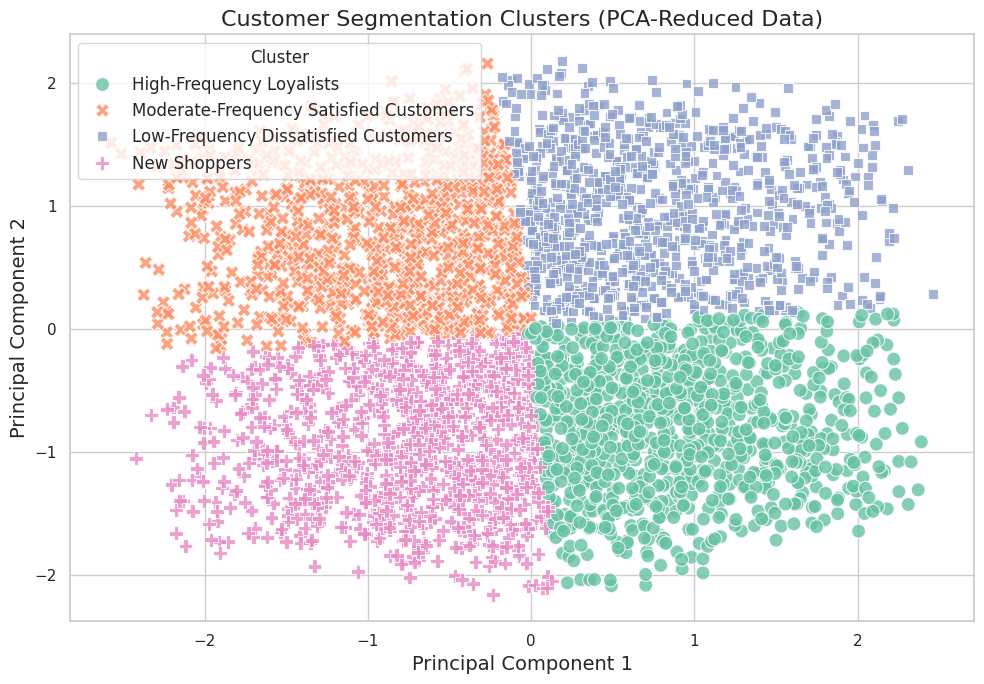

In [198]:
# CUSTOMER SEGMENTATION

# Apply preprocessing to data for clustering
processed_data = preprocessor.fit_transform(shopping)
pca = PCA(n_components=2)  # Reduce dimensions for visualization and clustering
reduced_data = pca.fit_transform(processed_data)

# Apply KMeans for clustering
kmeans = KMeans(n_clusters=4, random_state=123)
shopping['Cluster'] = kmeans.fit_predict(reduced_data)

# Evaluate Clustering
silhouette = silhouette_score(reduced_data, shopping['Cluster'])
print(f"Silhouette Score for Clustering: {silhouette:.2f}")

# Define cluster names using new column-based logic
cluster_names = {
    0: "High-Frequency Loyalists",
    1: "Moderate-Frequency Satisfied Customers",
    2: "Low-Frequency Dissatisfied Customers",
    3: "New Shoppers"
}

# Map clusters to names in the dataset
shopping['Cluster Name'] = shopping['Cluster'].map(cluster_names)

# Create a scatter plot for the PCA-reduced data with clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=reduced_data[:, 0],  # First principal component
    y=reduced_data[:, 1],  # Second principal component
    hue=shopping['Cluster Name'],     # Cluster labels
    palette='Set2',
    style=shopping['Cluster Name'],
    s=100,
    alpha=0.8
)

# Add labels and title
plt.title('Customer Segmentation Clusters (PCA-Reduced Data)', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=14)
plt.ylabel('Principal Component 2', fontsize=14)
plt.legend(title='Cluster', fontsize=12, loc='best')
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()


In [199]:
# PREDICTIVE MODELS

# Prepare data for classification and regression
X = shopping[categorical_cols + numerical_cols]
y_classification = shopping[classification_target]
y_regression = regression_target

# Encode target variables for classification
label_encoder = LabelEncoder()
y_classification = label_encoder.fit_transform(y_classification)

# Split data into training and testing sets
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    X, y_classification, test_size=0.2, random_state=123)

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X, y_regression, test_size=0.2, random_state=123)


In [200]:
# CLASSIFICATION MODEL

# Random Forest for Classification
classification_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=123))
])

# Hyperparameter tuning for classification
param_grid_class = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20, None]
}
grid_search_class = GridSearchCV(classification_model, param_grid_class, cv=5, scoring='accuracy')
grid_search_class.fit(X_train_class, y_train_class)

# Evaluate Classification Model
best_class_model = grid_search_class.best_estimator_
y_pred_class = best_class_model.predict(X_test_class)
print(f"Classification Report:\n{classification_report(y_test_class, y_pred_class)}")


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.81      0.89       570
           1       0.65      0.98      0.78       210

    accuracy                           0.85       780
   macro avg       0.82      0.89      0.84       780
weighted avg       0.90      0.85      0.86       780



In [201]:
# REGRESSION MODEL

# Random Forest for Regression
regression_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=123))
])

# Hyperparameter tuning for regression
param_grid_reg = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [10, 20, None]
}
grid_search_reg = GridSearchCV(regression_model, param_grid_reg, cv=5, scoring='neg_mean_squared_error')
grid_search_reg.fit(X_train_reg, y_train_reg)

# Evaluate Regression Model
best_reg_model = grid_search_reg.best_estimator_

# Predict and evaluate the regression model
y_pred_reg = best_reg_model.predict(X_test_reg)
mse = mean_squared_error(y_test_reg, y_pred_reg)
print(f"Mean Squared Error for Regression: {mse:.2f}")

Mean Squared Error for Regression: 4.09


In [202]:
# KEY INSIGHTS

print("Key Insights:")
print(f"- Customer segmentation identified 4 distinct clusters with a silhouette score of {silhouette:.2f}.")
print(f"- The best classification model achieved an accuracy of {grid_search_class.best_score_:.2f} for subscription prediction.")
print(f"- The regression model showed an MSE of {mse:.2f} for sales forecasting.")

Key Insights:
- Customer segmentation identified 4 distinct clusters with a silhouette score of 0.37.
- The best classification model achieved an accuracy of 0.83 for subscription prediction.
- The regression model showed an MSE of 4.09 for sales forecasting.


In [203]:
# SAVE MODELS

joblib.dump(best_class_model, 'classification_model.pkl')
joblib.dump(best_reg_model, 'regression_model.pkl')

['regression_model.pkl']